In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (True/1 for real tokens, False/0 for padding)
        # to match model's convention. model internally inverts to match pytorch transformer expectation.
        padding_mask = torch.ones(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = False
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([32, 277])
torch.Size([32, 277])
tensor([ 17,  33,  58,  77,  97,  51, 100,  70,  56,  39,  98,  17,  38, 141,
         73,  26,  62,  21,  62,  39,   4,  62,  88,  74,  46,  77,  79, 103,
         59, 102,  76,  58])

Vocabulary size: 519


In [4]:
import importlib
import model_arch
import scheduler
importlib.reload(model_arch)
importlib.reload(scheduler)


from model_arch import simplifiedV2
from scheduler import AdaptiveSchedule

In [5]:
def train_step(model, batch, scheduler, optimizer):

    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
   
    
    # Forward pass through model
    logits = model(
        input_ids,
        t=timesteps,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is pad_token_id
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    

    # Calculate entropy for scheduler
    with torch.no_grad():
        probs = F.softmax(logits, dim=-1)
        
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        probs = torch.clamp(probs, min=eps, max=1-eps)
        
        entropy = -(probs * torch.log(probs)).sum(dim=-1)  # [batch_size, seq_len]
        
        # Calculate average entropy per sequence, accounting for padding
        # First create a mask for valid (non-padding) positions
        seq_lengths = padding_mask.sum(dim=1).float()  # [batch_size]
        
        # Sum entropy across sequence length and divide by number of valid tokens
        avg_entropy_per_seq = (entropy * padding_mask).sum(dim=1) / seq_lengths  # [batch_size]
        
        
        # Add average entropy data to scheduler (one per sequence)
        scheduler.add_data(
            avg_entropy_per_seq,
            timesteps
        )

    # Backprop with gradient clipping
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return loss.item(), entropy.mean().item()


def eval_step(model, batch):
    """Single evaluation step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing input_ids and padding_mask
        
    Returns:
        loss: scalar evaluation loss
        entropy: entropy statistics
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Get tmin and tmax from scheduler
    tmin = scheduler.tmin
    tmax = scheduler.tmax
    
    # Uniform random sampling between tmin and tmax
    timesteps = tmin + (tmax - tmin) * torch.rand(batch_size, device=input_ids.device)
    
    # Forward pass through model
    logits = model(
        input_ids,
        t=timesteps,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy
    probs = F.softmax(logits, dim=-1)
    eps = 1e-8
    probs = torch.clamp(probs, min=eps, max=1-eps)
    entropy = -(probs * torch.log(probs)).sum(dim=-1)
    
    return loss.item(), entropy.mean().item()

In [6]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
    """Runs one epoch of training or evaluation for the CDCD model"""
    model.train() if train_run else model.eval()
    total_loss = 0
    total_entropy = 0
    num_batches = 0
    
    # Setup progress bar
    mode = "Train" if train_run else "Eval"
    epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
    pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
    device = next(model.parameters()).device

    # Main loop
    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if train_run:
            loss, entropy = train_step(model, batch, scheduler, optimizer)
        else:
            # Use separate eval step without optimizer/scheduler
            loss, entropy = eval_step(model, batch)
        
        # Accumulate metrics
        total_loss += loss
        total_entropy += entropy
        num_batches += 1
        
        # Update progress bar
        avg_loss = total_loss / num_batches
        avg_entropy = total_entropy / num_batches
        pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
        pbar.update(1)
    
    pbar.close()
    
    # Calculate final averages
    avg_loss = total_loss / num_batches
    avg_entropy = total_entropy / num_batches
    
    # Update scheduler parameters if training
    if train_run and epoch_num>10:
        scheduler.update_optimal_parameters(history=10_000)
    
    return {
        "loss": avg_loss,
        "entropy": avg_entropy,
        "num_batches": num_batches
    }

In [7]:
def train_simple(
    model,
    train_dataloader,
    eval_dataloader,
    noise_scheduler,
    num_epochs,
    learning_rate=1e-4,
    patience=5,
    save_dir="checkpoints",
    device="cuda"
):
    """Simple training loop with basic LR reduction on plateau
    """
    import torch
    from pathlib import Path
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_eval_loss = float('inf')
    epochs_without_improvement = 0
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        train_metrics = run_epoch(
            model=model,
            dataloader=train_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=True,
            epoch_num=epoch+1
        )
        
        # Evaluation phase
        eval_metrics = run_epoch(
            model=model,
            dataloader=eval_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=False,
            epoch_num=epoch+1
        )
        
        # Save best model and handle early stopping
        if eval_metrics['loss'] < best_eval_loss:
            best_eval_loss = eval_metrics['loss']
            epochs_without_improvement = 0
            
            torch.save(model.state_dict(), save_dir / 'best_model.pt')
        else:
            epochs_without_improvement += 1
            
            # Reduce learning rate if no improvement
            if epochs_without_improvement == patience:
                current_lr = optimizer.param_groups[0]['lr']
                new_lr = current_lr / 2
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                epochs_without_improvement = 0
                print(f"Reducing learning rate to {new_lr}")
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Eval Loss: {eval_metrics['loss']:.4f}")
    
    # Load best model
    #model.load_state_dict(torch.load(save_dir / 'best_model.pt'))
    return model

In [8]:
import importlib
import model_arch
import scheduler
importlib.reload(model_arch)
importlib.reload(scheduler)

from model_arch import simplifiedV2
from scheduler import AdaptiveSchedule

In [9]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 64  # Dimension of embeddings, default 32
transformer_dim = embedding_dim
num_heads = 16  # Number of attention heads
num_layers = 3  # Number of transformer layers
t_min = 1 # Minimum time value
t_max = 17  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519
embedding_scale=0.1 # probably needs to be tuned

model = simplifiedV2(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    transformer_dim=transformer_dim,
    num_layers = num_layers,
    vocab_size = vocab_size,
    dropout=0.1,
    embedding_scale=embedding_scale
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 10,
    sigma = 6,
    height = 1,
    offset = 0.1
)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [11]:


for batch in train_loader:
# Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    train_step(model,batch, scheduler, optimizer)
    break

In [13]:
model = train_simple(
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    noise_scheduler=scheduler,
    num_epochs=60,
    patience = 5,
    learning_rate=1e-4,
    save_dir="checkpoints"
)

Epoch 1 Loss: 4.8671, Entropy: 5.2484: 100%|██████████| 51/51 [00:00<00:00, 148.12it/s]


Epoch 1/60
Train Loss: 4.8786
Eval Loss: 4.8671


Epoch 2 Loss: 4.8108, Entropy: 5.2401: 100%|██████████| 51/51 [00:00<00:00, 149.58it/s]


Epoch 2/60
Train Loss: 4.8364
Eval Loss: 4.8108


Epoch 3 Loss: 4.7757, Entropy: 5.2330: 100%|██████████| 51/51 [00:00<00:00, 149.62it/s]


Epoch 3/60
Train Loss: 4.8346
Eval Loss: 4.7757


Epoch 4 Loss: 4.7803, Entropy: 5.2415: 100%|██████████| 51/51 [00:00<00:00, 148.06it/s]


Epoch 4/60
Train Loss: 4.8158
Eval Loss: 4.7803


Epoch 5 Loss: 4.6994, Entropy: 5.2012: 100%|██████████| 51/51 [00:00<00:00, 149.50it/s]


Epoch 5/60
Train Loss: 4.8015
Eval Loss: 4.6994


Epoch 6 Loss: 4.7646, Entropy: 5.1946: 100%|██████████| 51/51 [00:00<00:00, 149.80it/s]


Epoch 6/60
Train Loss: 4.7344
Eval Loss: 4.7646


Epoch 7 Loss: 4.7897, Entropy: 5.2068: 100%|██████████| 51/51 [00:00<00:00, 146.99it/s]


Epoch 7/60
Train Loss: 4.7432
Eval Loss: 4.7897


Epoch 8 Loss: 4.7234, Entropy: 5.1846: 100%|██████████| 51/51 [00:00<00:00, 147.58it/s]


Epoch 8/60
Train Loss: 4.7609
Eval Loss: 4.7234


Epoch 9 Loss: 4.7608, Entropy: 5.1774: 100%|██████████| 51/51 [00:00<00:00, 149.17it/s]


Epoch 9/60
Train Loss: 4.6746
Eval Loss: 4.7608


Epoch 10 Loss: 4.6532, Entropy: 5.1265: 100%|██████████| 51/51 [00:00<00:00, 149.80it/s]


Epoch 10/60
Train Loss: 4.7259
Eval Loss: 4.6532


Epoch 11 Loss: 4.7112, Entropy: 5.1797: 100%|██████████| 203/203 [00:04<00:00, 48.58it/s]
2025-02-25 08:55:46,247 - INFO - Updated optimal parameters: mu=0.10000000000000002, sigma=1.4639325857703747, height=7.9841896514116835, offset=-2.359035786742611


[0.10000000000000002, 1.4639325857703747, 7.9841896514116835, -2.359035786742611]


Epoch 11 Loss: 4.6906, Entropy: 5.1269: 100%|██████████| 51/51 [00:00<00:00, 146.21it/s]


Epoch 11/60
Train Loss: 4.7112
Eval Loss: 4.6906


Epoch 12 Loss: 2.8155, Entropy: 4.5913: 100%|██████████| 203/203 [00:04<00:00, 48.50it/s]
2025-02-25 08:55:50,806 - INFO - Updated optimal parameters: mu=0.28079146444602576, sigma=1.1103688433966983, height=9.349871797614384, offset=-3.8187600261212915


[0.28079146444602576, 1.1103688433966983, 9.349871797614384, -3.8187600261212915]


Epoch 12 Loss: 4.6441, Entropy: 5.0366: 100%|██████████| 51/51 [00:00<00:00, 149.42it/s]


Epoch 12/60
Train Loss: 2.8155
Eval Loss: 4.6441


Epoch 13 Loss: 2.4226, Entropy: 4.3604: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:55:55,351 - INFO - Updated optimal parameters: mu=0.4970302532544247, sigma=0.9738612201636002, height=9.264848133249071, offset=-3.9377758693578393


[0.4970302532544247, 0.9738612201636002, 9.264848133249071, -3.9377758693578393]


Epoch 13 Loss: 4.7026, Entropy: 5.0218: 100%|██████████| 51/51 [00:00<00:00, 149.41it/s]


Epoch 13/60
Train Loss: 2.4226
Eval Loss: 4.7026


Epoch 14 Loss: 2.1663, Entropy: 4.1799: 100%|██████████| 203/203 [00:04<00:00, 48.50it/s]
2025-02-25 08:55:59,896 - INFO - Updated optimal parameters: mu=0.7064687998598369, sigma=1.0578014583879398, height=8.50409657343662, offset=-3.2407185200702053


[0.7064687998598369, 1.0578014583879398, 8.50409657343662, -3.2407185200702053]


Epoch 14 Loss: 4.6707, Entropy: 4.9766: 100%|██████████| 51/51 [00:00<00:00, 149.37it/s]


Epoch 14/60
Train Loss: 2.1663
Eval Loss: 4.6707


Epoch 15 Loss: 2.1031, Entropy: 4.0499: 100%|██████████| 203/203 [00:04<00:00, 48.56it/s]
2025-02-25 08:56:04,436 - INFO - Updated optimal parameters: mu=0.8854839931391882, sigma=1.2126891282391663, height=7.936012951296608, offset=-2.658116806888834


[0.8854839931391882, 1.2126891282391663, 7.936012951296608, -2.658116806888834]


Epoch 15 Loss: 4.6758, Entropy: 4.9672: 100%|██████████| 51/51 [00:00<00:00, 149.32it/s]


Epoch 15/60
Train Loss: 2.1031
Eval Loss: 4.6758


Epoch 16 Loss: 2.1252, Entropy: 3.9611: 100%|██████████| 203/203 [00:04<00:00, 48.53it/s]
2025-02-25 08:56:08,977 - INFO - Updated optimal parameters: mu=1.05907685565671, sigma=1.2990506004066502, height=7.668003020657899, offset=-2.374796631374148


[1.05907685565671, 1.2990506004066502, 7.668003020657899, -2.374796631374148]


Epoch 16 Loss: 4.6650, Entropy: 4.9455: 100%|██████████| 51/51 [00:00<00:00, 149.49it/s]


Epoch 16/60
Train Loss: 2.1252
Eval Loss: 4.6650


Epoch 17 Loss: 2.1750, Entropy: 3.8946: 100%|██████████| 203/203 [00:04<00:00, 48.56it/s]
2025-02-25 08:56:13,515 - INFO - Updated optimal parameters: mu=1.20236180761566, sigma=1.3842775341433449, height=7.480904511970104, offset=-2.1645356069116666


[1.20236180761566, 1.3842775341433449, 7.480904511970104, -2.1645356069116666]


Epoch 17 Loss: 4.6916, Entropy: 4.9605: 100%|██████████| 51/51 [00:00<00:00, 149.54it/s]


Reducing learning rate to 5e-05
Epoch 17/60
Train Loss: 2.1750
Eval Loss: 4.6916


Epoch 18 Loss: 2.2134, Entropy: 3.8421: 100%|██████████| 203/203 [00:04<00:00, 48.58it/s]
2025-02-25 08:56:18,048 - INFO - Updated optimal parameters: mu=1.315709524901892, sigma=1.473573089766616, height=7.393262033195779, offset=-2.037421443151088


[1.315709524901892, 1.473573089766616, 7.393262033195779, -2.037421443151088]


Epoch 18 Loss: 4.6074, Entropy: 4.8889: 100%|██████████| 51/51 [00:00<00:00, 145.89it/s]


Epoch 18/60
Train Loss: 2.2134
Eval Loss: 4.6074


Epoch 19 Loss: 2.2652, Entropy: 3.8212: 100%|██████████| 203/203 [00:04<00:00, 48.49it/s]
2025-02-25 08:56:22,605 - INFO - Updated optimal parameters: mu=1.3731018046464616, sigma=1.5400448996065357, height=7.3574258257025775, offset=-1.9813647946127413


[1.3731018046464616, 1.5400448996065357, 7.3574258257025775, -1.9813647946127413]


Epoch 19 Loss: 4.6274, Entropy: 4.9199: 100%|██████████| 51/51 [00:00<00:00, 149.40it/s]


Epoch 19/60
Train Loss: 2.2652
Eval Loss: 4.6274


Epoch 20 Loss: 2.3265, Entropy: 3.8114: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:56:27,144 - INFO - Updated optimal parameters: mu=1.4210140450558817, sigma=1.597447605222513, height=7.380053276772252, offset=-1.9734189774530786


[1.4210140450558817, 1.597447605222513, 7.380053276772252, -1.9734189774530786]


Epoch 20 Loss: 4.6809, Entropy: 4.9344: 100%|██████████| 51/51 [00:00<00:00, 149.59it/s]


Epoch 20/60
Train Loss: 2.3265
Eval Loss: 4.6809


Epoch 21 Loss: 2.3621, Entropy: 3.8030: 100%|██████████| 203/203 [00:04<00:00, 48.54it/s]
2025-02-25 08:56:31,684 - INFO - Updated optimal parameters: mu=1.4728219037564914, sigma=1.641217571806009, height=7.430209926474462, offset=-1.9821682072998084


[1.4728219037564914, 1.641217571806009, 7.430209926474462, -1.9821682072998084]


Epoch 21 Loss: 4.5866, Entropy: 4.8472: 100%|██████████| 51/51 [00:00<00:00, 149.30it/s]


Epoch 21/60
Train Loss: 2.3621
Eval Loss: 4.5866


Epoch 22 Loss: 2.4198, Entropy: 3.7790: 100%|██████████| 203/203 [00:04<00:00, 48.58it/s]
2025-02-25 08:56:36,227 - INFO - Updated optimal parameters: mu=1.5188858305310957, sigma=1.72329907807848, height=7.479897925607355, offset=-1.9853243427202925


[1.5188858305310957, 1.72329907807848, 7.479897925607355, -1.9853243427202925]


Epoch 22 Loss: 4.6241, Entropy: 4.8880: 100%|██████████| 51/51 [00:00<00:00, 149.42it/s]


Epoch 22/60
Train Loss: 2.4198
Eval Loss: 4.6241


Epoch 23 Loss: 2.5113, Entropy: 3.8057: 100%|██████████| 203/203 [00:04<00:00, 48.55it/s]
2025-02-25 08:56:40,771 - INFO - Updated optimal parameters: mu=1.556962984085445, sigma=1.7831081178222017, height=7.565778978675442, offset=-2.0198886215500327


[1.556962984085445, 1.7831081178222017, 7.565778978675442, -2.0198886215500327]


Epoch 23 Loss: 4.5903, Entropy: 4.8794: 100%|██████████| 51/51 [00:00<00:00, 149.34it/s]


Epoch 23/60
Train Loss: 2.5113
Eval Loss: 4.5903


Epoch 24 Loss: 2.4996, Entropy: 3.7768: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:56:45,309 - INFO - Updated optimal parameters: mu=1.587028603143861, sigma=1.828268610596458, height=7.634566807459586, offset=-2.0542517157554925


[1.587028603143861, 1.828268610596458, 7.634566807459586, -2.0542517157554925]


Epoch 24 Loss: 4.5437, Entropy: 4.8341: 100%|██████████| 51/51 [00:00<00:00, 149.39it/s]


Epoch 24/60
Train Loss: 2.4996
Eval Loss: 4.5437


Epoch 25 Loss: 2.5373, Entropy: 3.7613: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:56:49,851 - INFO - Updated optimal parameters: mu=1.6157164892771845, sigma=1.8217059827842468, height=7.663327967652475, offset=-2.0800116379686977


[1.6157164892771845, 1.8217059827842468, 7.663327967652475, -2.0800116379686977]


Epoch 25 Loss: 4.5733, Entropy: 4.8557: 100%|██████████| 51/51 [00:00<00:00, 146.99it/s]


Epoch 25/60
Train Loss: 2.5373
Eval Loss: 4.5733


Epoch 26 Loss: 2.5521, Entropy: 3.7507: 100%|██████████| 203/203 [00:04<00:00, 48.54it/s]
2025-02-25 08:56:54,395 - INFO - Updated optimal parameters: mu=1.6546226937444224, sigma=1.8516745249408089, height=7.666883568739937, offset=-2.061834610065751


[1.6546226937444224, 1.8516745249408089, 7.666883568739937, -2.061834610065751]


Epoch 26 Loss: 4.6155, Entropy: 4.8674: 100%|██████████| 51/51 [00:00<00:00, 149.44it/s]


Epoch 26/60
Train Loss: 2.5521
Eval Loss: 4.6155


Epoch 27 Loss: 2.5755, Entropy: 3.7387: 100%|██████████| 203/203 [00:04<00:00, 48.56it/s]
2025-02-25 08:56:58,932 - INFO - Updated optimal parameters: mu=1.6956609450253617, sigma=1.8904195278819889, height=7.682274836422188, offset=-2.053728330543889


[1.6956609450253617, 1.8904195278819889, 7.682274836422188, -2.053728330543889]


Epoch 27 Loss: 4.5773, Entropy: 4.8107: 100%|██████████| 51/51 [00:00<00:00, 149.84it/s]


Epoch 27/60
Train Loss: 2.5755
Eval Loss: 4.5773


Epoch 28 Loss: 2.5899, Entropy: 3.7217: 100%|██████████| 203/203 [00:04<00:00, 48.52it/s]
2025-02-25 08:57:03,472 - INFO - Updated optimal parameters: mu=1.7244740213828649, sigma=1.8974195575824995, height=7.686104469599811, offset=-2.053244015251426


[1.7244740213828649, 1.8974195575824995, 7.686104469599811, -2.053244015251426]


Epoch 28 Loss: 4.6382, Entropy: 4.8607: 100%|██████████| 51/51 [00:00<00:00, 149.40it/s]


Epoch 28/60
Train Loss: 2.5899
Eval Loss: 4.6382


Epoch 29 Loss: 2.6029, Entropy: 3.7002: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:57:08,009 - INFO - Updated optimal parameters: mu=1.775074788395014, sigma=1.8947072475595441, height=7.688759655384998, offset=-2.0382609149645234


[1.775074788395014, 1.8947072475595441, 7.688759655384998, -2.0382609149645234]


Epoch 29 Loss: 4.5618, Entropy: 4.8124: 100%|██████████| 51/51 [00:00<00:00, 149.53it/s]


Reducing learning rate to 2.5e-05
Epoch 29/60
Train Loss: 2.6029
Eval Loss: 4.5618


Epoch 30 Loss: 2.6024, Entropy: 3.6872: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:57:12,546 - INFO - Updated optimal parameters: mu=1.8178359360691496, sigma=1.9546843513069214, height=7.684848644558767, offset=-2.001945552909399


[1.8178359360691496, 1.9546843513069214, 7.684848644558767, -2.001945552909399]


Epoch 30 Loss: 4.6052, Entropy: 4.8522: 100%|██████████| 51/51 [00:00<00:00, 148.47it/s]


Epoch 30/60
Train Loss: 2.6024
Eval Loss: 4.6052


Epoch 31 Loss: 2.6561, Entropy: 3.7037: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:57:17,084 - INFO - Updated optimal parameters: mu=1.8327122099884672, sigma=1.9686263141991682, height=7.710745125072772, offset=-2.009908000821633


[1.8327122099884672, 1.9686263141991682, 7.710745125072772, -2.009908000821633]


Epoch 31 Loss: 4.5701, Entropy: 4.8323: 100%|██████████| 51/51 [00:00<00:00, 149.55it/s]


Epoch 31/60
Train Loss: 2.6561
Eval Loss: 4.5701


Epoch 32 Loss: 2.6640, Entropy: 3.6888: 100%|██████████| 203/203 [00:04<00:00, 48.51it/s]
2025-02-25 08:57:21,625 - INFO - Updated optimal parameters: mu=1.8421036935757376, sigma=1.950235834399499, height=7.7189986174549805, offset=-2.0154044376077764


[1.8421036935757376, 1.950235834399499, 7.7189986174549805, -2.0154044376077764]


Epoch 32 Loss: 4.6179, Entropy: 4.8337: 100%|██████████| 51/51 [00:00<00:00, 148.33it/s]


Epoch 32/60
Train Loss: 2.6640
Eval Loss: 4.6179


Epoch 33 Loss: 2.6184, Entropy: 3.6606: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:57:26,161 - INFO - Updated optimal parameters: mu=1.8585635171500812, sigma=1.9588930502640687, height=7.702475097353431, offset=-1.9997888299381499


[1.8585635171500812, 1.9588930502640687, 7.702475097353431, -1.9997888299381499]


Epoch 33 Loss: 4.5298, Entropy: 4.7922: 100%|██████████| 51/51 [00:00<00:00, 149.65it/s]


Epoch 33/60
Train Loss: 2.6184
Eval Loss: 4.5298


Epoch 34 Loss: 2.6670, Entropy: 3.6766: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:57:30,702 - INFO - Updated optimal parameters: mu=1.8757631448370258, sigma=1.9599954372154307, height=7.690771999526333, offset=-1.990040915197091


[1.8757631448370258, 1.9599954372154307, 7.690771999526333, -1.990040915197091]


Epoch 34 Loss: 4.5909, Entropy: 4.8211: 100%|██████████| 51/51 [00:00<00:00, 149.71it/s]


Epoch 34/60
Train Loss: 2.6670
Eval Loss: 4.5909


Epoch 35 Loss: 2.6901, Entropy: 3.6872: 100%|██████████| 203/203 [00:04<00:00, 48.53it/s]
2025-02-25 08:57:35,241 - INFO - Updated optimal parameters: mu=1.9095927468320335, sigma=1.9803223707389042, height=7.706609539922762, offset=-1.976442895239832


[1.9095927468320335, 1.9803223707389042, 7.706609539922762, -1.976442895239832]


Epoch 35 Loss: 4.6016, Entropy: 4.8152: 100%|██████████| 51/51 [00:00<00:00, 148.95it/s]


Epoch 35/60
Train Loss: 2.6901
Eval Loss: 4.6016


Epoch 36 Loss: 2.7195, Entropy: 3.6905: 100%|██████████| 203/203 [00:04<00:00, 48.56it/s]
2025-02-25 08:57:39,780 - INFO - Updated optimal parameters: mu=1.9316222225344695, sigma=1.9919364120392227, height=7.714053184217102, offset=-1.971251562805815


[1.9316222225344695, 1.9919364120392227, 7.714053184217102, -1.971251562805815]


Epoch 36 Loss: 4.6159, Entropy: 4.8423: 100%|██████████| 51/51 [00:00<00:00, 149.28it/s]


Epoch 36/60
Train Loss: 2.7195
Eval Loss: 4.6159


Epoch 37 Loss: 2.6868, Entropy: 3.6828: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:57:44,313 - INFO - Updated optimal parameters: mu=1.9379004679869536, sigma=1.98149412902563, height=7.694212905801524, offset=-1.9662564248847312


[1.9379004679869536, 1.98149412902563, 7.694212905801524, -1.9662564248847312]


Epoch 37 Loss: 4.5574, Entropy: 4.8033: 100%|██████████| 51/51 [00:00<00:00, 148.96it/s]


Epoch 37/60
Train Loss: 2.6868
Eval Loss: 4.5574


Epoch 38 Loss: 2.6681, Entropy: 3.6584: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:57:48,849 - INFO - Updated optimal parameters: mu=1.9499303736420803, sigma=1.9549245405106481, height=7.6641760824039755, offset=-1.9507928293508028


[1.9499303736420803, 1.9549245405106481, 7.6641760824039755, -1.9507928293508028]


Epoch 38 Loss: 4.5639, Entropy: 4.7936: 100%|██████████| 51/51 [00:00<00:00, 142.53it/s]


Reducing learning rate to 1.25e-05
Epoch 38/60
Train Loss: 2.6681
Eval Loss: 4.5639


Epoch 39 Loss: 2.6778, Entropy: 3.6540: 100%|██████████| 203/203 [00:04<00:00, 48.43it/s]
2025-02-25 08:57:53,418 - INFO - Updated optimal parameters: mu=1.9724088975253826, sigma=1.9781758591324536, height=7.649625331475346, offset=-1.9191641565084085


[1.9724088975253826, 1.9781758591324536, 7.649625331475346, -1.9191641565084085]


Epoch 39 Loss: 4.6040, Entropy: 4.8217: 100%|██████████| 51/51 [00:00<00:00, 132.38it/s]


Epoch 39/60
Train Loss: 2.6778
Eval Loss: 4.6040


Epoch 40 Loss: 2.7135, Entropy: 3.6638: 100%|██████████| 203/203 [00:04<00:00, 48.36it/s]
2025-02-25 08:57:58,015 - INFO - Updated optimal parameters: mu=1.981120240172898, sigma=1.9938603606119945, height=7.656310113823472, offset=-1.9159608094701512


[1.981120240172898, 1.9938603606119945, 7.656310113823472, -1.9159608094701512]


Epoch 40 Loss: 4.5946, Entropy: 4.7951: 100%|██████████| 51/51 [00:00<00:00, 146.07it/s]


Epoch 40/60
Train Loss: 2.7135
Eval Loss: 4.5946


Epoch 41 Loss: 2.6772, Entropy: 3.6582: 100%|██████████| 203/203 [00:04<00:00, 48.53it/s]
2025-02-25 08:58:02,562 - INFO - Updated optimal parameters: mu=1.9927000057247388, sigma=1.9903665212302917, height=7.661196470291687, offset=-1.9218885291479886


[1.9927000057247388, 1.9903665212302917, 7.661196470291687, -1.9218885291479886]


Epoch 41 Loss: 4.6081, Entropy: 4.8268: 100%|██████████| 51/51 [00:00<00:00, 146.26it/s]


Epoch 41/60
Train Loss: 2.6772
Eval Loss: 4.6081


Epoch 42 Loss: 2.6673, Entropy: 3.6400: 100%|██████████| 203/203 [00:04<00:00, 48.52it/s]
2025-02-25 08:58:07,112 - INFO - Updated optimal parameters: mu=1.9925744764193183, sigma=1.9588260221382239, height=7.636878182930765, offset=-1.9138704406270768


[1.9925744764193183, 1.9588260221382239, 7.636878182930765, -1.9138704406270768]


Epoch 42 Loss: 4.5790, Entropy: 4.7951: 100%|██████████| 51/51 [00:00<00:00, 146.64it/s]


Epoch 42/60
Train Loss: 2.6673
Eval Loss: 4.5790


Epoch 43 Loss: 2.7111, Entropy: 3.6536: 100%|██████████| 203/203 [00:04<00:00, 48.61it/s]
2025-02-25 08:58:11,652 - INFO - Updated optimal parameters: mu=2.016953126146117, sigma=1.9906349130851027, height=7.6386897234222735, offset=-1.8884580677663776


[2.016953126146117, 1.9906349130851027, 7.6386897234222735, -1.8884580677663776]


Epoch 43 Loss: 4.6529, Entropy: 4.8511: 100%|██████████| 51/51 [00:00<00:00, 146.29it/s]


Reducing learning rate to 6.25e-06
Epoch 43/60
Train Loss: 2.7111
Eval Loss: 4.6529


Epoch 44 Loss: 2.6987, Entropy: 3.6395: 100%|██████████| 203/203 [00:04<00:00, 48.56it/s]
2025-02-25 08:58:16,195 - INFO - Updated optimal parameters: mu=2.0296992158650298, sigma=1.986379691625581, height=7.646988920624598, offset=-1.8937049618940898


[2.0296992158650298, 1.986379691625581, 7.646988920624598, -1.8937049618940898]


Epoch 44 Loss: 4.5762, Entropy: 4.8062: 100%|██████████| 51/51 [00:00<00:00, 145.11it/s]


Epoch 44/60
Train Loss: 2.6987
Eval Loss: 4.5762


Epoch 45 Loss: 2.6982, Entropy: 3.6392: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:58:20,741 - INFO - Updated optimal parameters: mu=2.031494776241249, sigma=1.9722373874417507, height=7.62707463931901, offset=-1.8854926433978834


[2.031494776241249, 1.9722373874417507, 7.62707463931901, -1.8854926433978834]


Epoch 45 Loss: 4.5725, Entropy: 4.8181: 100%|██████████| 51/51 [00:00<00:00, 146.33it/s]


Epoch 45/60
Train Loss: 2.6982
Eval Loss: 4.5725


Epoch 46 Loss: 2.7092, Entropy: 3.6319: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:58:25,284 - INFO - Updated optimal parameters: mu=2.0499288049078324, sigma=1.9889781574287417, height=7.6247550858947575, offset=-1.8708389335673172


[2.0499288049078324, 1.9889781574287417, 7.6247550858947575, -1.8708389335673172]


Epoch 46 Loss: 4.5169, Entropy: 4.7777: 100%|██████████| 51/51 [00:00<00:00, 146.20it/s]


Epoch 46/60
Train Loss: 2.7092
Eval Loss: 4.5169


Epoch 47 Loss: 2.7167, Entropy: 3.6383: 100%|██████████| 203/203 [00:04<00:00, 48.52it/s]
2025-02-25 08:58:29,836 - INFO - Updated optimal parameters: mu=2.0520924278661927, sigma=1.9887222537290612, height=7.6240134820072525, offset=-1.869565466352172


[2.0520924278661927, 1.9887222537290612, 7.6240134820072525, -1.869565466352172]


Epoch 47 Loss: 4.5485, Entropy: 4.7816: 100%|██████████| 51/51 [00:00<00:00, 145.93it/s]


Epoch 47/60
Train Loss: 2.7167
Eval Loss: 4.5485


Epoch 48 Loss: 2.7018, Entropy: 3.6318: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:58:34,378 - INFO - Updated optimal parameters: mu=2.051063644190378, sigma=1.9819051101092726, height=7.614695075965985, offset=-1.8679481581113244


[2.051063644190378, 1.9819051101092726, 7.614695075965985, -1.8679481581113244]


Epoch 48 Loss: 4.6375, Entropy: 4.8284: 100%|██████████| 51/51 [00:00<00:00, 146.21it/s]


Epoch 48/60
Train Loss: 2.7018
Eval Loss: 4.6375


Epoch 49 Loss: 2.7250, Entropy: 3.6396: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:58:38,920 - INFO - Updated optimal parameters: mu=2.060735092739291, sigma=1.999739001073655, height=7.62839627420993, offset=-1.8621132462348724


[2.060735092739291, 1.999739001073655, 7.62839627420993, -1.8621132462348724]


Epoch 49 Loss: 4.5604, Entropy: 4.7828: 100%|██████████| 51/51 [00:00<00:00, 145.94it/s]


Epoch 49/60
Train Loss: 2.7250
Eval Loss: 4.5604


Epoch 50 Loss: 2.7701, Entropy: 3.6588: 100%|██████████| 203/203 [00:04<00:00, 48.57it/s]
2025-02-25 08:58:43,465 - INFO - Updated optimal parameters: mu=2.0646429006408398, sigma=2.0187783923682283, height=7.646989714853785, offset=-1.8706256917804247


[2.0646429006408398, 2.0187783923682283, 7.646989714853785, -1.8706256917804247]


Epoch 50 Loss: 4.6050, Entropy: 4.7993: 100%|██████████| 51/51 [00:00<00:00, 146.83it/s]


Epoch 50/60
Train Loss: 2.7701
Eval Loss: 4.6050


Epoch 51 Loss: 2.7310, Entropy: 3.6430: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:58:48,006 - INFO - Updated optimal parameters: mu=2.06628818039044, sigma=2.0224731944131698, height=7.669335522246401, offset=-1.8844089134819109


[2.06628818039044, 2.0224731944131698, 7.669335522246401, -1.8844089134819109]


Epoch 51 Loss: 4.6510, Entropy: 4.8198: 100%|██████████| 51/51 [00:00<00:00, 143.78it/s]


Reducing learning rate to 3.125e-06
Epoch 51/60
Train Loss: 2.7310
Eval Loss: 4.6510


Epoch 52 Loss: 2.7260, Entropy: 3.6300: 100%|██████████| 203/203 [00:04<00:00, 48.50it/s]
2025-02-25 08:58:52,563 - INFO - Updated optimal parameters: mu=2.061839126461397, sigma=2.0272150193789393, height=7.673784862766082, offset=-1.8911748193451905


[2.061839126461397, 2.0272150193789393, 7.673784862766082, -1.8911748193451905]


Epoch 52 Loss: 4.6317, Entropy: 4.8204: 100%|██████████| 51/51 [00:00<00:00, 146.18it/s]


Epoch 52/60
Train Loss: 2.7260
Eval Loss: 4.6317


Epoch 53 Loss: 2.7182, Entropy: 3.6390: 100%|██████████| 203/203 [00:04<00:00, 48.53it/s]
2025-02-25 08:58:57,113 - INFO - Updated optimal parameters: mu=2.0483410275154172, sigma=2.008691713906091, height=7.66673522129265, offset=-1.8977636178026083


[2.0483410275154172, 2.008691713906091, 7.66673522129265, -1.8977636178026083]


Epoch 53 Loss: 4.6284, Entropy: 4.8051: 100%|██████████| 51/51 [00:00<00:00, 146.00it/s]


Epoch 53/60
Train Loss: 2.7182
Eval Loss: 4.6284


Epoch 54 Loss: 2.7642, Entropy: 3.6497: 100%|██████████| 203/203 [00:04<00:00, 48.54it/s]
2025-02-25 08:59:01,661 - INFO - Updated optimal parameters: mu=2.069058261075875, sigma=2.0361126215242016, height=7.687869926933847, offset=-1.892834599220622


[2.069058261075875, 2.0361126215242016, 7.687869926933847, -1.892834599220622]


Epoch 54 Loss: 4.6350, Entropy: 4.8352: 100%|██████████| 51/51 [00:00<00:00, 146.00it/s]


Epoch 54/60
Train Loss: 2.7642
Eval Loss: 4.6350


Epoch 55 Loss: 2.7241, Entropy: 3.6358: 100%|██████████| 203/203 [00:04<00:00, 48.58it/s]
2025-02-25 08:59:06,207 - INFO - Updated optimal parameters: mu=2.057451454944996, sigma=2.005355131155129, height=7.6723431796031, offset=-1.902328745678233


[2.057451454944996, 2.005355131155129, 7.6723431796031, -1.902328745678233]


Epoch 55 Loss: 4.5063, Entropy: 4.7467: 100%|██████████| 51/51 [00:00<00:00, 146.05it/s]


Epoch 55/60
Train Loss: 2.7241
Eval Loss: 4.5063


Epoch 56 Loss: 2.7505, Entropy: 3.6433: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:59:10,754 - INFO - Updated optimal parameters: mu=2.063107522007809, sigma=1.9982582750140319, height=7.651057099879125, offset=-1.886772030690878


[2.063107522007809, 1.9982582750140319, 7.651057099879125, -1.886772030690878]


Epoch 56 Loss: 4.5047, Entropy: 4.7397: 100%|██████████| 51/51 [00:00<00:00, 145.49it/s]


Epoch 56/60
Train Loss: 2.7505
Eval Loss: 4.5047


Epoch 57 Loss: 2.7605, Entropy: 3.6418: 100%|██████████| 203/203 [00:04<00:00, 48.48it/s]
2025-02-25 08:59:15,311 - INFO - Updated optimal parameters: mu=2.0656585948015804, sigma=2.0182288691289187, height=7.646858131293303, offset=-1.8738805827964966


[2.0656585948015804, 2.0182288691289187, 7.646858131293303, -1.8738805827964966]


Epoch 57 Loss: 4.6646, Entropy: 4.8411: 100%|██████████| 51/51 [00:00<00:00, 146.08it/s]


Epoch 57/60
Train Loss: 2.7605
Eval Loss: 4.6646


Epoch 58 Loss: 2.7323, Entropy: 3.6311: 100%|██████████| 203/203 [00:04<00:00, 48.58it/s]
2025-02-25 08:59:19,857 - INFO - Updated optimal parameters: mu=2.0755948704872633, sigma=2.0535436365841977, height=7.6815171310232495, offset=-1.8834468322796716


[2.0755948704872633, 2.0535436365841977, 7.6815171310232495, -1.8834468322796716]


Epoch 58 Loss: 4.6151, Entropy: 4.8082: 100%|██████████| 51/51 [00:00<00:00, 145.93it/s]


Epoch 58/60
Train Loss: 2.7323
Eval Loss: 4.6151


Epoch 59 Loss: 2.7686, Entropy: 3.6484: 100%|██████████| 203/203 [00:04<00:00, 48.54it/s]
2025-02-25 08:59:24,404 - INFO - Updated optimal parameters: mu=2.0749029491060282, sigma=2.0546489518354365, height=7.714024653385947, offset=-1.9073215899545461


[2.0749029491060282, 2.0546489518354365, 7.714024653385947, -1.9073215899545461]


Epoch 59 Loss: 4.4713, Entropy: 4.7337: 100%|██████████| 51/51 [00:00<00:00, 145.89it/s]


Epoch 59/60
Train Loss: 2.7686
Eval Loss: 4.4713


Epoch 60 Loss: 2.7980, Entropy: 3.6673: 100%|██████████| 203/203 [00:04<00:00, 48.59it/s]
2025-02-25 08:59:28,953 - INFO - Updated optimal parameters: mu=2.07423172228491, sigma=2.0559083045291255, height=7.7306573021430935, offset=-1.9164631411781041


[2.07423172228491, 2.0559083045291255, 7.7306573021430935, -1.9164631411781041]


Epoch 60 Loss: 4.6345, Entropy: 4.8035: 100%|██████████| 51/51 [00:00<00:00, 146.07it/s]

Epoch 60/60
Train Loss: 2.7980
Eval Loss: 4.6345


In [ ]:
scheduler.sample((batch_size,))

tensor([1.4484, 4.1973, 1.0940, 4.7788, 1.9715, 2.9093, 3.3046, 1.1494, 2.2964,
        2.5795, 1.7524, 1.3596, 1.6432, 3.1612, 2.7002, 5.6184, 1.4087, 2.0303,
        4.8800, 2.5583, 1.3402, 2.3839, 3.1227, 2.4914, 1.8453, 1.9606, 1.4926,
        1.5624, 2.5288, 2.2760, 1.2908, 2.8442])

In [ ]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 324332
Number of entropy points: 324332
Number of parameter sets: 41
Time range: 1.0000154972076416 to 16.999942779541016
Entropy range: 0.12855961918830872 to 6.094426155090332


In [ ]:
scheduler.parameters_history[-1]

[2.0267416071960613,
 1.0169091181096421,
 6.554219818415501,
 -0.9680031363018301]

Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.098 to 5.686')

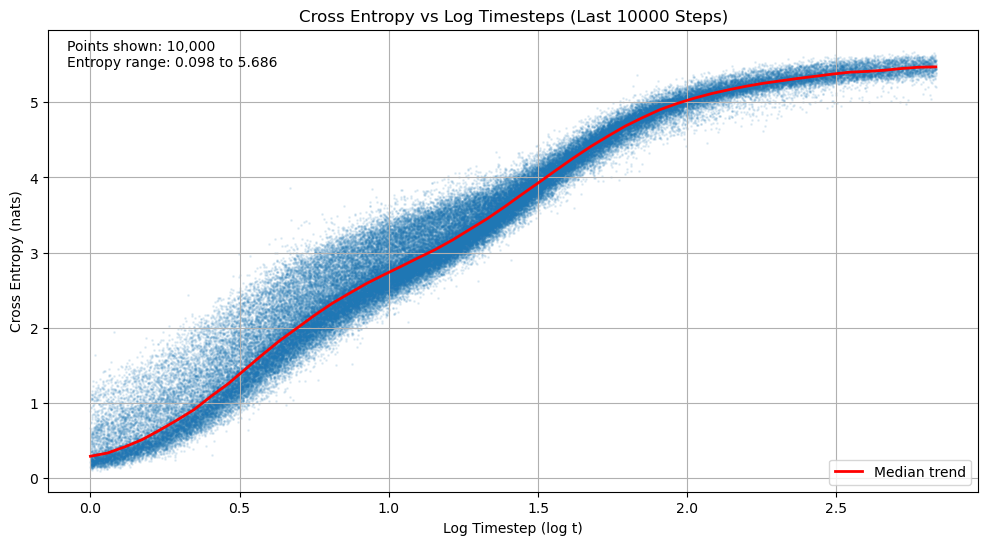

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100_000:])
entropy = np.array(scheduler.entropy[-100_000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

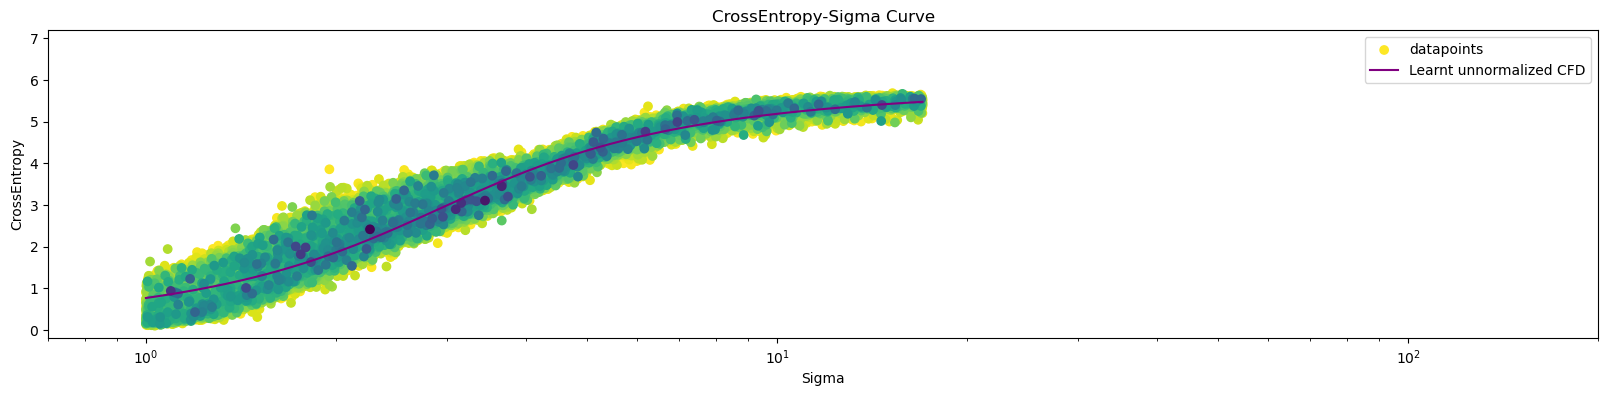

In [15]:
scheduler.plot_entropy_time_curve()

/mnt/mnemo9/mpelus/matlas/cdcd_multi_train/cdcd_hmp/simplifiedV2/scheduler.py:160: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


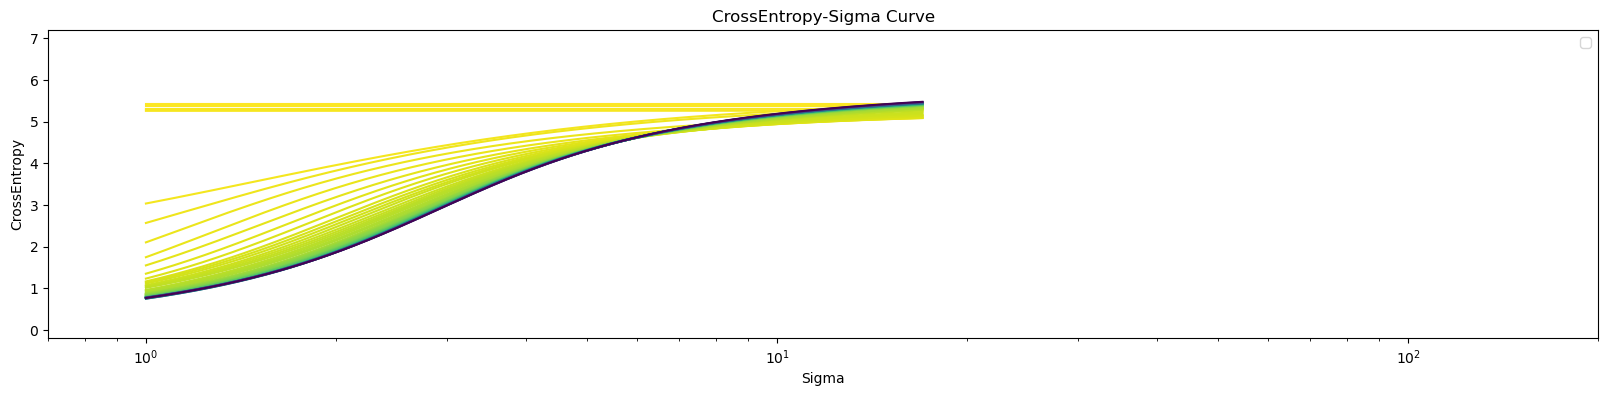

In [16]:
scheduler.plot_training_curves()

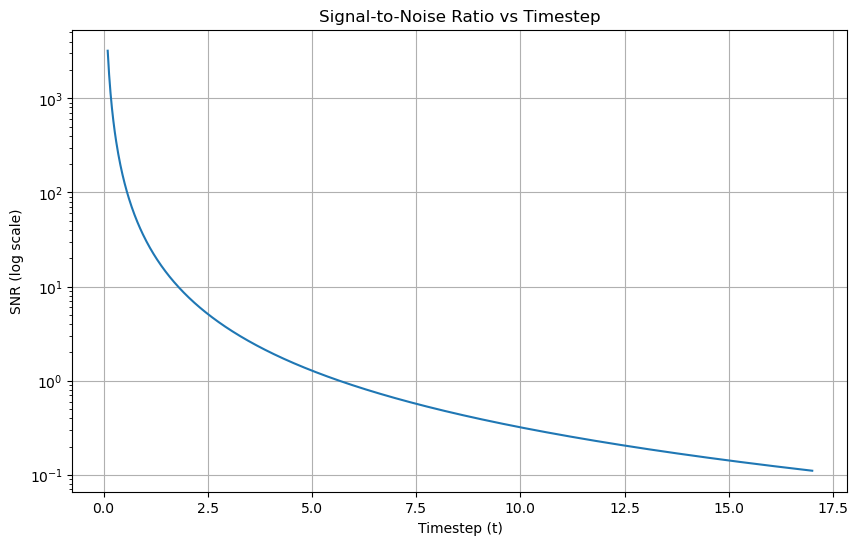

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

embed_dim = 32  # typical embedding dimension
t = np.linspace(0.1, 17, 1000)
snr = embed_dim/(t**2)

plt.figure(figsize=(10, 6))
plt.plot(t, snr)
plt.yscale('log')
plt.title('Signal-to-Noise Ratio vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('SNR (log scale)')
plt.grid(True)
plt.show()

In [17]:
seq_len = 20
n_steps = 50
batch_size = 1

# Get timesteps as a 1D sequence
timesteps = scheduler.make_timesteps(
    n_steps,
    tmin=t_min,
    tmax=t_max,
    device=device
)

# Initialize noise
image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * torch.sqrt(timesteps[0])

print(image.shape)
init_predicted = torch.softmax(model.final_projection(model.transformer(image)), dim=-1)
print(max(init_predicted[0][0]))
print(min(init_predicted[0][0]))

for t in timesteps:
    with torch.no_grad():
        # Process time for time embedding
        log_t = torch.log(t.squeeze(-1).squeeze(-1) + 1e-8) / 4
        time_emb = model.time_embedding(log_t)
        time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)
        #print('Time emb shape: ', time_emb.shape)
        current_image = torch.cat([image, time_emb], dim=-1)
        #print('Current image: ', current_image.shape)
        proj_to_transformer_dim = model.embedding_projection(current_image)
        #print('proj to trans shape: ', proj_to_transformer_dim.shape)
        predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
        update = predicted @ model.token_embedding.weight
        dt = timesteps[(timesteps == t).nonzero().item() + 1] - t if (timesteps == t).nonzero().item() < len(timesteps) - 1 else 0
        image = image - dt * ((update - image)/(t**2))
        
#Final prediction
with torch.no_grad():
    log_t = torch.log(timesteps[-1].squeeze(-1).squeeze(-1) + 1e-8) / 4
    time_emb = model.time_embedding(log_t)
    time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)
    #print('Time emb shape: ', time_emb.shape)
    current_image = torch.cat([image, time_emb], dim=-1)
    #print('Current image: ', current_image.shape)
    proj_to_transformer_dim = model.embedding_projection(current_image)
    #print('proj to trans shape: ', proj_to_transformer_dim.shape)
    predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
    print(predicted.shape)
    print(max(predicted[0][0]))
    print(min(predicted[0][0]))
    
        

torch.Size([1, 20, 64])
tensor(0.0176, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(1.1011e-08, device='cuda:0', grad_fn=<UnbindBackward0>)
torch.Size([1, 20, 519])
tensor(0.0365, device='cuda:0')
tensor(2.6094e-08, device='cuda:0')


In [79]:
import matplotlib.pyplot as plt
import numpy as np

n_steps = 50
timesteps = scheduler.make_timesteps(
    n_steps,
    tmin=1,#t_min,
    tmax= 200,#t_max,
    device=device
)

timestep_values = []
prediction_entropy = []
update_magnitudes = []
image_magnitudes = []
max_probs = []
mean_probs = []
tokens_above_threshold = []

positions_to_track = [0, 5, 10]  # Track first, middle, and last positions
trajectory_embeddings = {pos: [] for pos in positions_to_track}
trajectory_predictions = {pos: [] for pos in positions_to_track}

#adjustor = torch.randn(batch_size, seq_len, model.embedding_dim, device=device)
image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * torch.sqrt(timesteps[0])
#image = (image + adjustor)/(torch.sqrt(t**2 + 1))
for t in timesteps:
    with torch.no_grad():
        
        # Process time for time embedding
        log_t = torch.log(t.squeeze(-1).squeeze(-1) + 1e-8) / 4
        time_emb = model.time_embedding(log_t)
        time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
        time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim) #try norming time

        time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)
        current_image = torch.cat([image, time_emb], dim=-1)
        proj_to_transformer_dim = model.embedding_projection(current_image)
        predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
        update = predicted @ model.token_embedding.weight
        
        # Collect metrics
        timestep_values.append(t.item())
        entropy = (-predicted * torch.log(predicted + 1e-8)).sum(-1).mean().item()
        prediction_entropy.append(entropy)
        update_mag = (update - image).abs().mean().item()
        update_magnitudes.append(update_mag)
        image_magnitudes.append(image.abs().mean().item())
        max_probs.append(predicted.max().item())
        mean_probs.append(predicted.mean().item())
        tokens_above_threshold.append((predicted > 0.1).float().sum().item())
        
        # Track trajectories
        for pos in positions_to_track:
            trajectory_embeddings[pos].append(image[0, pos].cpu().numpy())
            trajectory_predictions[pos].append(predicted[0, pos].cpu().numpy())

        # Update step
        dt = timesteps[(timesteps == t).nonzero().item() + 1] - t if (timesteps == t).nonzero().item() < len(timesteps) - 1 else 0
        image = image - dt * (( update - image)/(t**1))  # or whatever power of t you're testing
        #image = (image / (torch.norm(image, keepdim=True, p=2, dim=-1) + 1e-8)) * math.sqrt(model.embedding_dim)

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
fig.suptitle('Diffusion Process Metrics')

# Plot metrics
axes[0,0].plot(timestep_values, prediction_entropy)
axes[0,0].set_title('Prediction Entropy')
axes[0,0].set_xlabel('Timestep')
axes[0,0].set_ylabel('Entropy')

axes[0,1].plot(timestep_values, update_magnitudes)
axes[0,1].set_title('Update Magnitude')
axes[0,1].set_xlabel('Timestep')
axes[0,1].set_ylabel('Magnitude')

axes[1,0].plot(timestep_values, image_magnitudes)
axes[1,0].set_title('Image Magnitude')
axes[1,0].set_xlabel('Timestep')
axes[1,0].set_ylabel('Magnitude')

axes[1,1].plot(timestep_values, max_probs)
axes[1,1].plot(timestep_values, mean_probs)
axes[1,1].set_title('Prediction Probabilities')
axes[1,1].set_xlabel('Timestep')
axes[1,1].set_ylabel('Probability')
axes[1,1].legend(['Max Prob', 'Mean Prob'])

axes[2,0].plot(timestep_values, tokens_above_threshold)
axes[2,0].set_title('Tokens Above 0.1 Probability')
axes[2,0].set_xlabel('Timestep')
axes[2,0].set_ylabel('Count')

# Plot prediction distribution at final timestep
final_pred = predicted[0][0].cpu().numpy()
axes[2,1].hist(final_pred, bins=50)
axes[2,1].set_title('Final Prediction Distribution')
axes[2,1].set_xlabel('Probability')
axes[2,1].set_ylabel('Count')


# New trajectory plots
# Embedding trajectories
trajectory_data = np.array([trajectory_embeddings[pos] for pos in positions_to_track])
# Use PCA to reduce embedding dimension for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
trajectory_2d = [pca.fit_transform(traj) for traj in trajectory_data]

for i, pos in enumerate(positions_to_track):
    axes[3,0].plot(trajectory_2d[i][:, 0], trajectory_2d[i][:, 1], label=f'Pos {pos}')
    # Add arrows to show direction
    for j in range(len(trajectory_2d[i])-1):
        axes[3,0].arrow(trajectory_2d[i][j, 0], trajectory_2d[i][j, 1],
                       trajectory_2d[i][j+1, 0] - trajectory_2d[i][j, 0],
                       trajectory_2d[i][j+1, 1] - trajectory_2d[i][j, 1],
                       head_width=0.1, head_length=0.1, fc='k', ec='k', alpha=0.1)
axes[3,0].set_title('Embedding Trajectories (PCA)')
axes[3,0].legend()

# Top prediction probabilities over time
for pos in positions_to_track:
    top_probs = [np.max(pred) for pred in trajectory_predictions[pos]]
    axes[3,1].plot(timestep_values, top_probs, label=f'Pos {pos}')
axes[3,1].set_title('Top Prediction Probability Over Time')
axes[3,1].set_xlabel('Timestep')
axes[3,1].set_ylabel('Probability')
axes[3,1].legend()

plt.tight_layout()
plt.show()

RuntimeError: a Tensor with 4 elements cannot be converted to Scalar

Embedding shape: (519, 64)
Mean: -0.0005026441
Std: 0.09388879
Min: -0.35432413
Max: 0.36886463


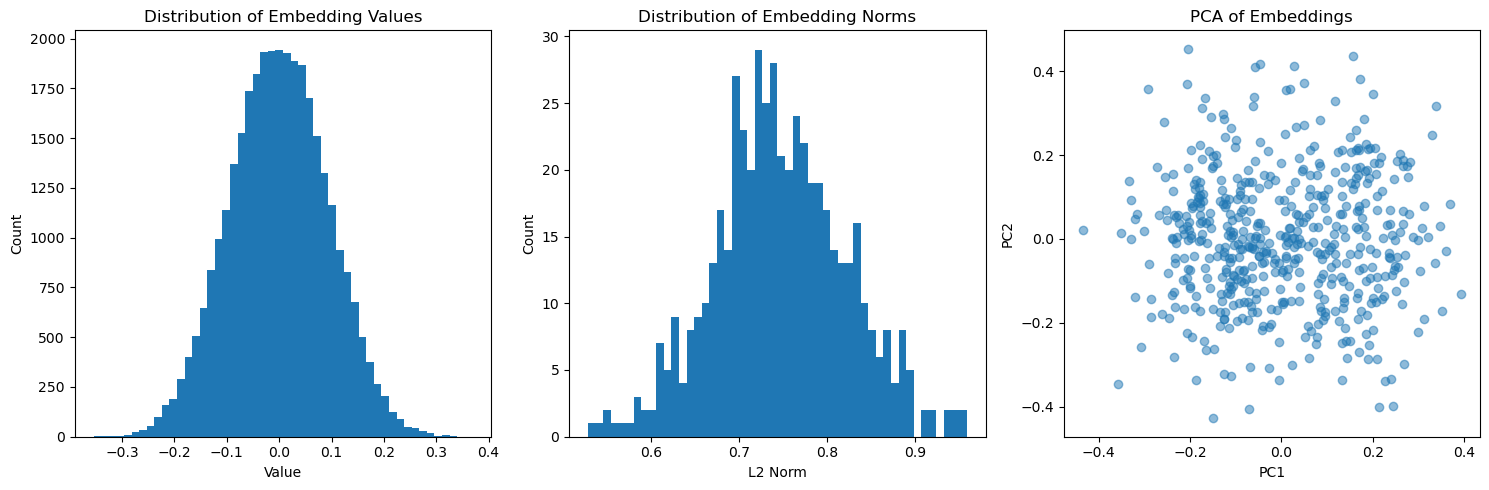

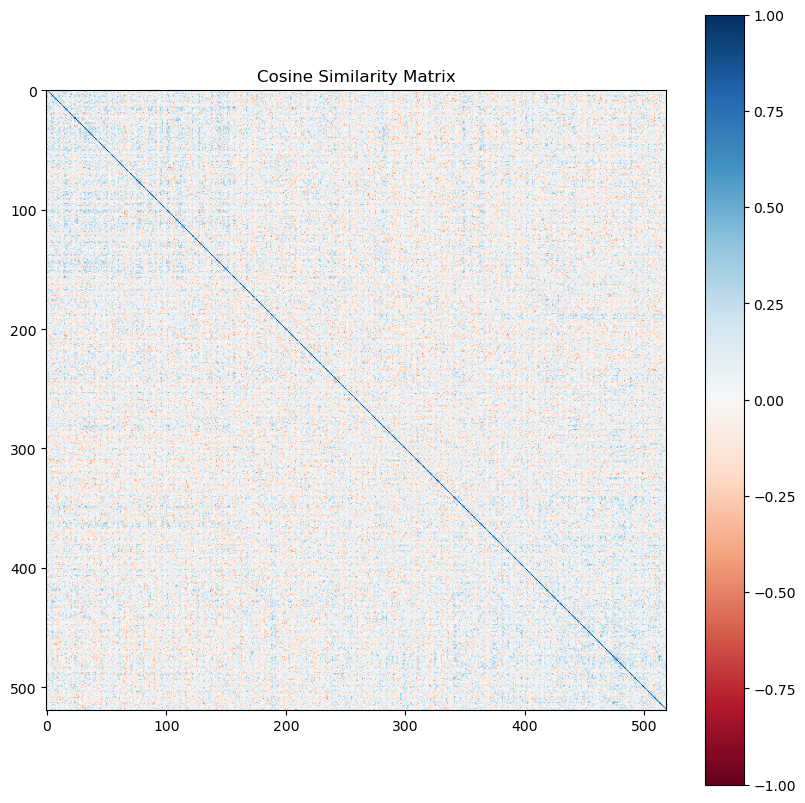

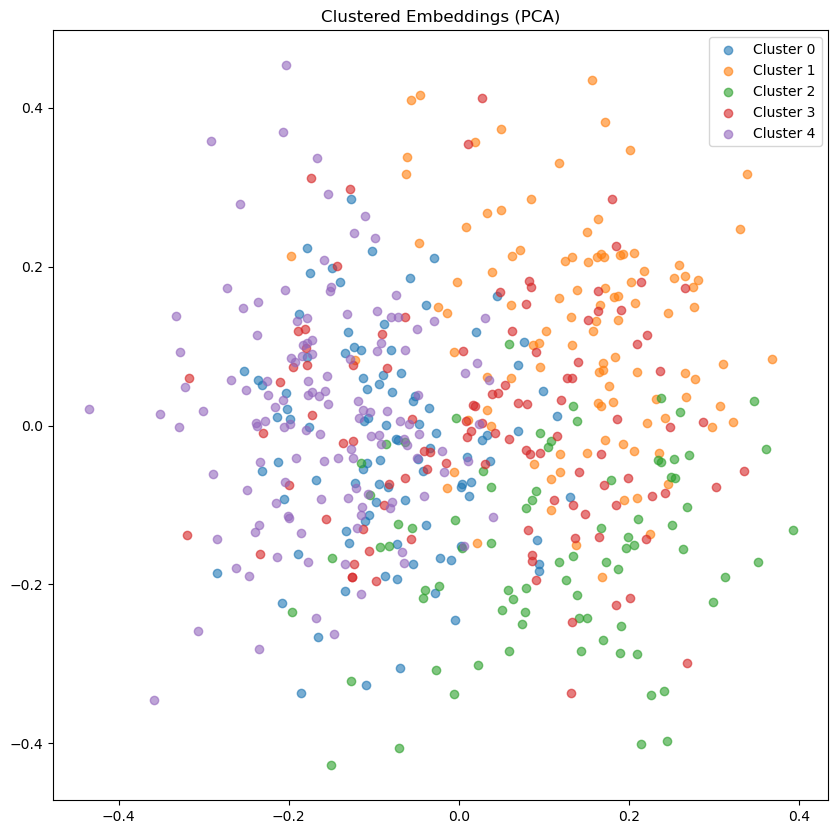

In [19]:
# Get the embedding weights
embeddings = model.token_embedding.weight.detach().cpu().numpy()

# Basic statistics
print("Embedding shape:", embeddings.shape)
print("Mean:", np.mean(embeddings))
print("Std:", np.std(embeddings))
print("Min:", np.min(embeddings))
print("Max:", np.max(embeddings))

# Distribution analysis
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(embeddings.flatten(), bins=50)
plt.title('Distribution of Embedding Values')
plt.xlabel('Value')
plt.ylabel('Count')

# Norm analysis
norms = np.linalg.norm(embeddings, axis=1)
plt.subplot(132)
plt.hist(norms, bins=50)
plt.title('Distribution of Embedding Norms')
plt.xlabel('L2 Norm')
plt.ylabel('Count')

# PCA of the embedding space
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
plt.subplot(133)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('PCA of Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

# Cosine similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(embeddings)
plt.figure(figsize=(10, 10))
plt.imshow(sim_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Cosine Similarity Matrix')
plt.show()

# Check for any obvious clusters
from sklearn.cluster import KMeans
n_clusters = 5  # adjust as needed
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    mask = clusters == i
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=f'Cluster {i}', alpha=0.6)
plt.title('Clustered Embeddings (PCA)')
plt.legend()
plt.show()

Cosine similarity range: -0.734 to 1.000


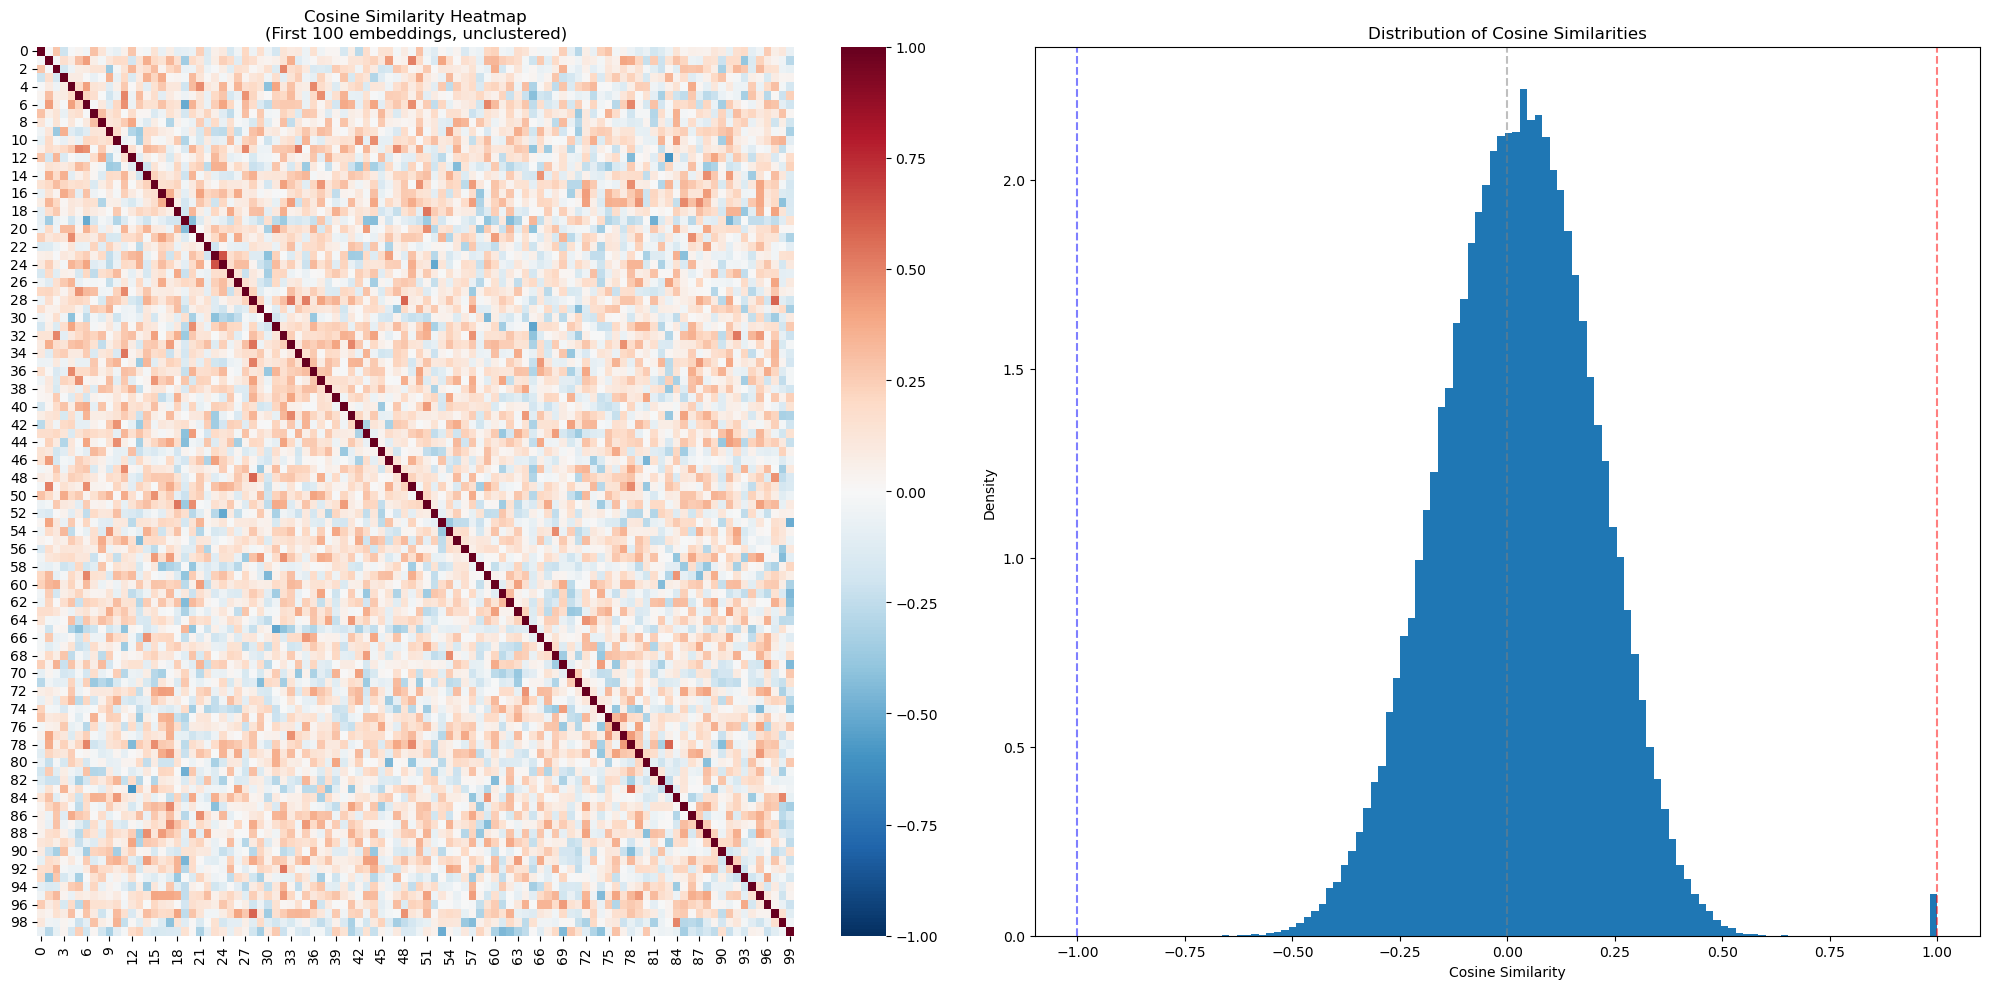

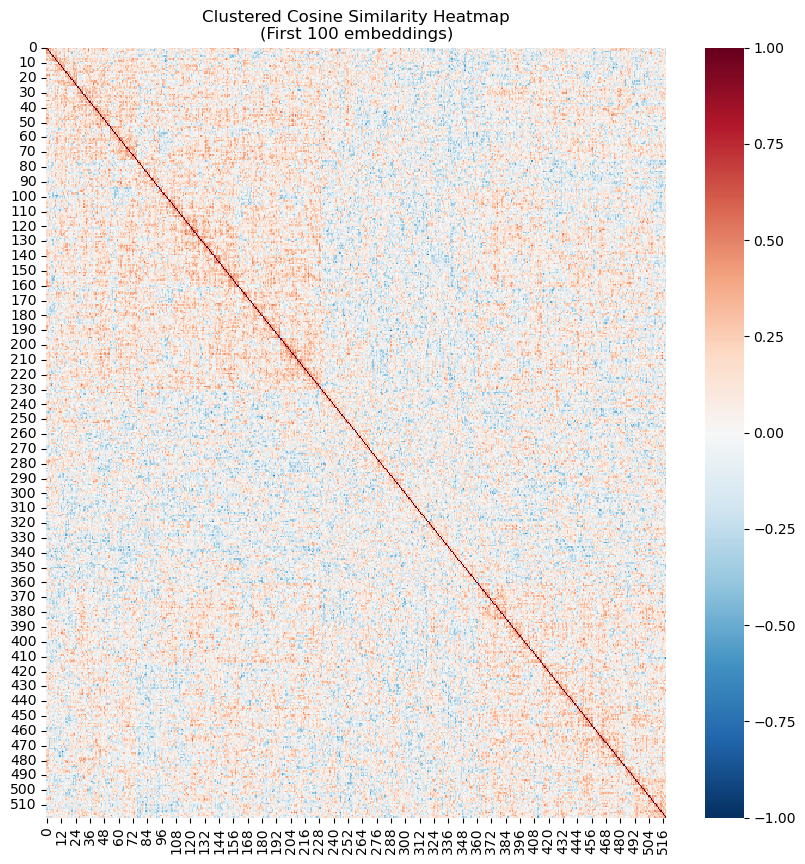

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

def plot_cosine_similarities_full_range(embeddings):
    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(embeddings)
    
    # Print range statistics
    print(f"Cosine similarity range: {cosine_sim.min():.3f} to {cosine_sim.max():.3f}")
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Full heatmap
    plt.subplot(121)
    sns.heatmap(cosine_sim[:100, :100],  # Using first 100x100 for better visibility
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                center=0)
    plt.title('Cosine Similarity Heatmap\n(First 100 embeddings, unclustered)')
    
    # Plot 2: Distribution
    plt.subplot(122)
    plt.hist(cosine_sim.flatten(), bins=100, density=True)
    plt.title('Distribution of Cosine Similarities')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    
    # Add vertical lines for reference
    plt.axvline(x=-1, color='blue', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

    # Now show clustered version
    plt.figure(figsize=(10, 10))
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(cosine_sim, method='ward')
    den = dendrogram(linkage_matrix, no_plot=True)
    reordered_idx = den['leaves']
    
    # Reorder the similarity matrix
    cosine_sim_clustered = cosine_sim[reordered_idx][:, reordered_idx]
    
    # Plot clustered heatmap
    sns.heatmap(cosine_sim_clustered[:519, :519],  # Using first 100x100 for better visibility
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                center=0)
    plt.title('Clustered Cosine Similarity Heatmap\n(First 100 embeddings)')
    plt.show()

# Run the analysis
plot_cosine_similarities_full_range(embeddings)

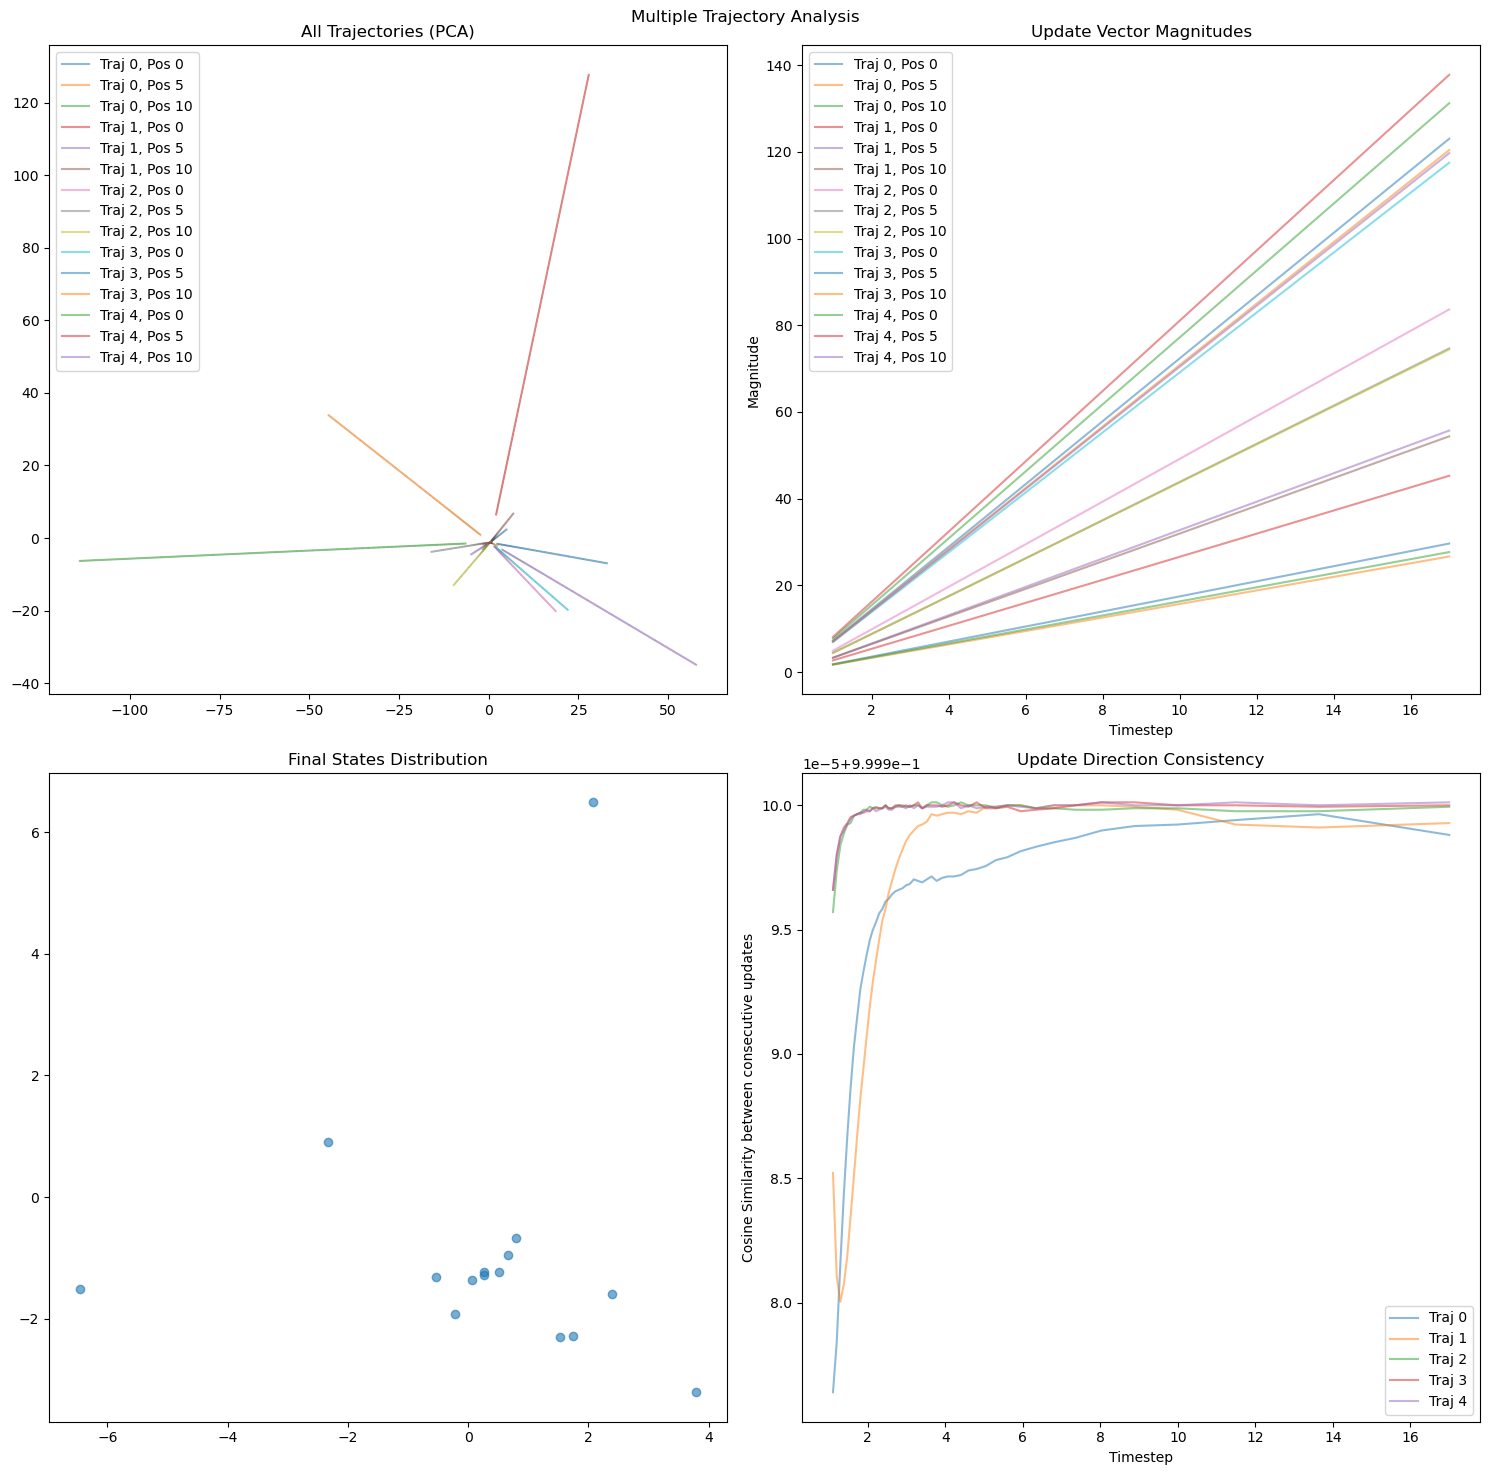

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

n_trajectories = 5
n_steps = 50
all_trajectories = []
positions_to_track = [0, 5, 10]

# Initialize different starting points
for i in range(n_trajectories):
    timestep_values = []
    trajectory_embeddings = {pos: [] for pos in positions_to_track}
    trajectory_updates = {pos: [] for pos in positions_to_track}
    
    # Try different initial scales
    scale = timesteps[0] * (i + 1) / n_trajectories
    image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * scale
    
    for t in timesteps:
        with torch.no_grad():
            log_t = torch.log(t.squeeze(-1).squeeze(-1) + 1e-8) / 4
            time_emb = model.time_embedding(log_t)
            time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
            time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim)
            
            time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)
            current_image = torch.cat([image, time_emb], dim=-1)
            proj_to_transformer_dim = model.embedding_projection(current_image)
            predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
            update = predicted @ model.token_embedding.weight
            
            # Track trajectories and updates
            for pos in positions_to_track:
                trajectory_embeddings[pos].append(image[0, pos].cpu().numpy())
                trajectory_updates[pos].append((update - image)[0, pos].cpu().numpy())
            
            timestep_values.append(t.item())
            
            dt = timesteps[(timesteps == t).nonzero().item() + 1] - t if (timesteps == t).nonzero().item() < len(timesteps) - 1 else 0
            image = image - dt * ((update - image)/(t**1))
    
    all_trajectories.append((trajectory_embeddings, trajectory_updates))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Multiple Trajectory Analysis')

# Plot all trajectories in PCA space
pca = PCA(n_components=2)
all_points = []
for traj, _ in all_trajectories:
    for pos in positions_to_track:
        all_points.extend(traj[pos])
all_points = np.array(all_points)
pca.fit(all_points)

for i, (traj, updates) in enumerate(all_trajectories):
    for pos in positions_to_track:
        trajectory_2d = pca.transform(traj[pos])
        axes[0,0].plot(trajectory_2d[:, 0], trajectory_2d[:, 1], 
                      label=f'Traj {i}, Pos {pos}', alpha=0.5)
        # Add arrows for direction
        for j in range(len(trajectory_2d)-1):
            axes[0,0].arrow(trajectory_2d[j, 0], trajectory_2d[j, 1],
                          trajectory_2d[j+1, 0] - trajectory_2d[j, 0],
                          trajectory_2d[j+1, 1] - trajectory_2d[j, 1],
                          head_width=0.1, head_length=0.1, fc='k', ec='k', alpha=0.1)
axes[0,0].set_title('All Trajectories (PCA)')
axes[0,0].legend()

# Plot update vector magnitudes over time
for i, (_, updates) in enumerate(all_trajectories):
    for pos in positions_to_track:
        update_mags = [np.linalg.norm(u) for u in updates[pos]]
        axes[0,1].plot(timestep_values, update_mags, 
                      label=f'Traj {i}, Pos {pos}', alpha=0.5)
axes[0,1].set_title('Update Vector Magnitudes')
axes[0,1].set_xlabel('Timestep')
axes[0,1].set_ylabel('Magnitude')
axes[0,1].legend()

# Plot final states
final_states = []
for traj, _ in all_trajectories:
    for pos in positions_to_track:
        final_states.append(traj[pos][-1])
final_states = np.array(final_states)
final_states_2d = pca.transform(final_states)
axes[1,0].scatter(final_states_2d[:, 0], final_states_2d[:, 1], alpha=0.6)
axes[1,0].set_title('Final States Distribution')

# Plot update vector directions over time
# Take a single position for clarity
pos_to_analyze = positions_to_track[0]
for i, (_, updates) in enumerate(all_trajectories):
    update_directions = []
    for j in range(len(updates[pos_to_analyze])-1):
        u1 = updates[pos_to_analyze][j]
        u2 = updates[pos_to_analyze][j+1]
        cos_sim = np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))
        update_directions.append(cos_sim)
    axes[1,1].plot(timestep_values[:-1], update_directions, 
                   label=f'Traj {i}', alpha=0.5)
axes[1,1].set_title('Update Direction Consistency')
axes[1,1].set_xlabel('Timestep')
axes[1,1].set_ylabel('Cosine Similarity between consecutive updates')
axes[1,1].legend()

plt.tight_layout()
plt.show()

Token weight section shape: (64, 64)
Time embedding section shape: (64, 64)

Token weights stats:
Mean: 0.0007385684
Std: 0.048365086
Abs mean: 0.039947078

Time weights stats:
Mean: -0.0009401767
Std: 0.05135719
Abs mean: 0.04408253


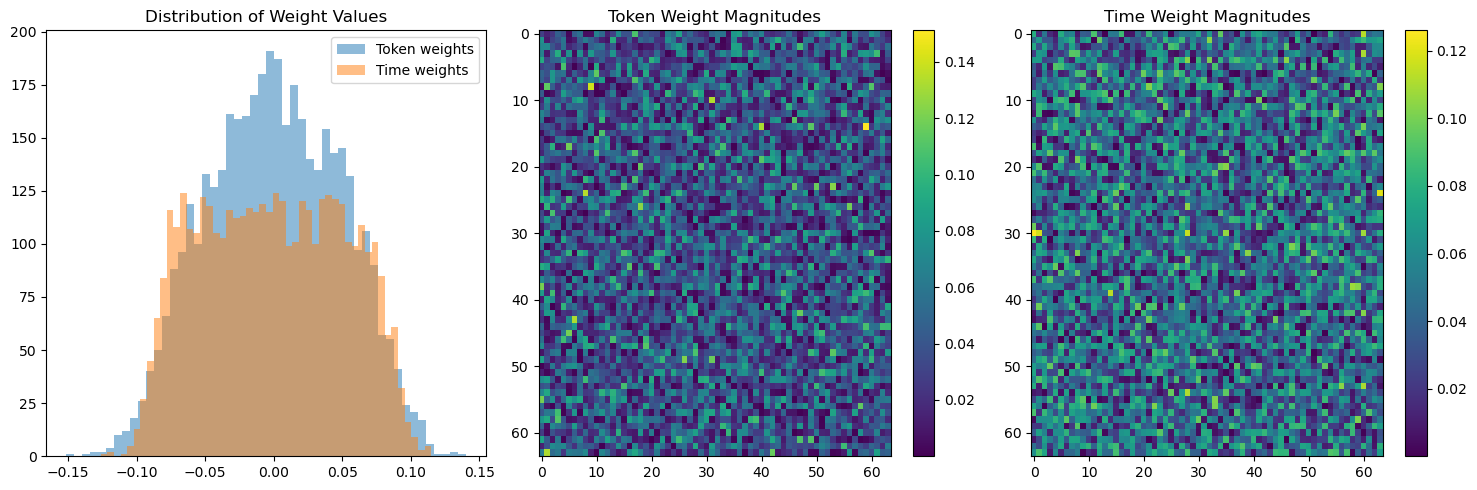

In [22]:
# Get the weights of the embedding projection layer
projection_weights = model.embedding_projection.weight.detach().cpu().numpy()

# The weights should be split between token embedding dims and time embedding dims
n_token_dims = model.embedding_dim  # 32 from earlier
n_time_dims = projection_weights.shape[1] - n_token_dims

# Split the weights
token_weights = projection_weights[:, :n_token_dims]
time_weights = projection_weights[:, n_token_dims:]

print("Token weight section shape:", token_weights.shape)
print("Time embedding section shape:", time_weights.shape)

# Compare statistics
print("\nToken weights stats:")
print("Mean:", np.mean(token_weights))
print("Std:", np.std(token_weights))
print("Abs mean:", np.mean(np.abs(token_weights)))

print("\nTime weights stats:")
print("Mean:", np.mean(time_weights))
print("Std:", np.std(time_weights))
print("Abs mean:", np.mean(np.abs(time_weights)))

# Visualize the relative magnitudes
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(token_weights.flatten(), bins=50, alpha=0.5, label='Token weights')
plt.hist(time_weights.flatten(), bins=50, alpha=0.5, label='Time weights')
plt.title('Distribution of Weight Values')
plt.legend()

plt.subplot(132)
plt.imshow(np.abs(token_weights), aspect='auto')
plt.title('Token Weight Magnitudes')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.abs(time_weights), aspect='auto')
plt.title('Time Weight Magnitudes')
plt.colorbar()

plt.tight_layout()
plt.show()

In [71]:
def generate_sample(
        
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=20,
    t_min=1,
    t_max=17,
    device='cuda'
):
    """
    Generate samples using a diffusion model.
    
    Args:
        model: The diffusion model with transformer, time_embedding, and token_embedding components
        scheduler: The scheduler object that creates timesteps
        batch_size: Number of samples to generate in parallel (default: 1)
        seq_len: Length of the sequence to generate (default: 10)
        n_steps: Number of diffusion steps (default: 20)
        t_min: Minimum timestep value (default: 1e-4)
        t_max: Maximum timestep value (default: 1.0)
        device: Device to run generation on (default: 'cuda')
    
    Returns:
        tuple: (final_predictions, generated_images)
    """
    
    # Get timesteps as a 1D sequence
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )

    # Initialize noise
    image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * timesteps[0]


    for t in timesteps:
        with torch.no_grad():
            #image = (image / (torch.norm(image, keepdim=True, p=2, dim=-1) + 1e-8)) * math.sqrt(model.embedding_dim)

            # Process time for time embedding
            log_t = torch.log(t.squeeze(-1).squeeze(-1) + 1e-8) / 4
            time_emb = model.time_embedding(log_t)

            time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
            time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim)


            # Convert time_emb from [32] to [1, 200, 32]
            time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)

            # Now concatenate along the feature dimension
            current_image = torch.cat([image, time_emb], dim=-1)

            proj_to_transformer_dim = model.embedding_projection(current_image)
            
            # Get predictions
            predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)

            
            # Update image
            normalized_embeddings = model.token_embedding.weight / torch.norm(model.token_embedding.weight, keepdim=True, p=2, dim=1)
            update = predicted @ normalized_embeddings
            dt = timesteps[(timesteps <= t).nonzero()[0][-1] + 1] - t if (timesteps <= t).nonzero()[0][-1] < len(timesteps) - 1 else 0
            image = image - dt * ((update - image)/t**0.9)
           

    # Final prediction
    with torch.no_grad():
        #image = (image / (torch.norm(image, keepdim=True, p=2, dim=-1) + 1e-8)) * math.sqrt(model.embedding_dim)
        log_t = torch.log(timesteps[-1].squeeze(-1).squeeze(-1) + 1e-8) / 4
        time_emb = model.time_embedding(log_t)
        #tryin norm
        time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
        time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim)


        time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)
        current_image = torch.cat([image, time_emb], dim=-1)
        proj_to_transformer_dim = model.embedding_projection(current_image)
        # Get predictions
        predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
        tokens = torch.argmax(predicted, dim=-1).tolist()
    
    return predicted, image, tokens

predicted, image, tokens = generate_sample(model, scheduler, t_min=1, t_max=17)

In [72]:
tokens

[[269, 0, 285, 0, 273, 252, 0, 364, 0, 0]]

In [73]:
# Assuming your model has a token_embedding attribute
padding_embedding = model.token_embedding.weight[0]

# Print its shape and some stats
print(f"Padding token embedding shape: {padding_embedding.shape}")
print(f"Padding token embedding mean: {padding_embedding.mean().item()}")
print(f"Padding token embedding std: {padding_embedding.std().item()}")
print(f"Padding token embedding norm: {torch.norm(padding_embedding).item()}")

# Optionally, visualize the first few values
print(f"First 10 values: {padding_embedding[:10].tolist()}")

Padding token embedding shape: torch.Size([64])
Padding token embedding mean: 0.0037651732563972473
Padding token embedding std: 0.10620243847370148
Padding token embedding norm: 0.843493640422821
First 10 values: [-0.07286253571510315, 0.03743685036897659, -0.23152197897434235, -0.023470215499401093, -0.0608350969851017, 0.1294669359922409, -0.09569862484931946, 0.16973361372947693, -0.19056262075901031, -0.2414633184671402]


In [42]:


def generate_unique_samples(
    model,
    scheduler,
    num_samples,
    lmin=5,
    lmax=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate multiple samples with varying lengths and deduplicate tokens within each sequence.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        num_samples: Number of samples to generate
        lmin: Minimum sequence length
        lmax: Maximum sequence length
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
        
    Returns:
        list[list[int]]: List of sequences, where each sequence contains unique tokens
    """
    unique_sequences = []
    
    for _ in range(num_samples):
        # Sample a random sequence length
        seq_len = torch.randint(low=lmin, high=lmax+1, size=(1,)).item()
        
        # Generate a single sample
        _, _, tokens = generate_sample(
            model,
            scheduler,
            batch_size=1,
            seq_len=seq_len,
            n_steps=n_steps,
            t_min=t_min,
            t_max=t_max,
            device=device
        )
        
        # Convert to list and get first sequence
        token_list = tokens[0]
        
        # Deduplicate while preserving order
        seen = set()
        unique_tokens = []
        for token in token_list:
            if token not in seen:
                seen.add(token)
                unique_tokens.append(token)
        
        unique_sequences.append(unique_tokens)
    
    return unique_sequences




In [43]:
prod, _, tokens = generate_sample(
    model,
    scheduler,
    batch_size=3,
    seq_len=15,
    n_steps=50,
    t_min=1,
    t_max=17,
    device=device
)

In [44]:
max(prod[0][0])

tensor(0.8208, device='cuda:0')

In [45]:
sequences = generate_unique_samples(
    model,
    scheduler,
    num_samples=200,
    lmin=5,   # Minimum sequence length
    lmax=200,  # Maximum sequence length
    n_steps=50,
    t_min=1,
    t_max=17,
    device=device
)


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


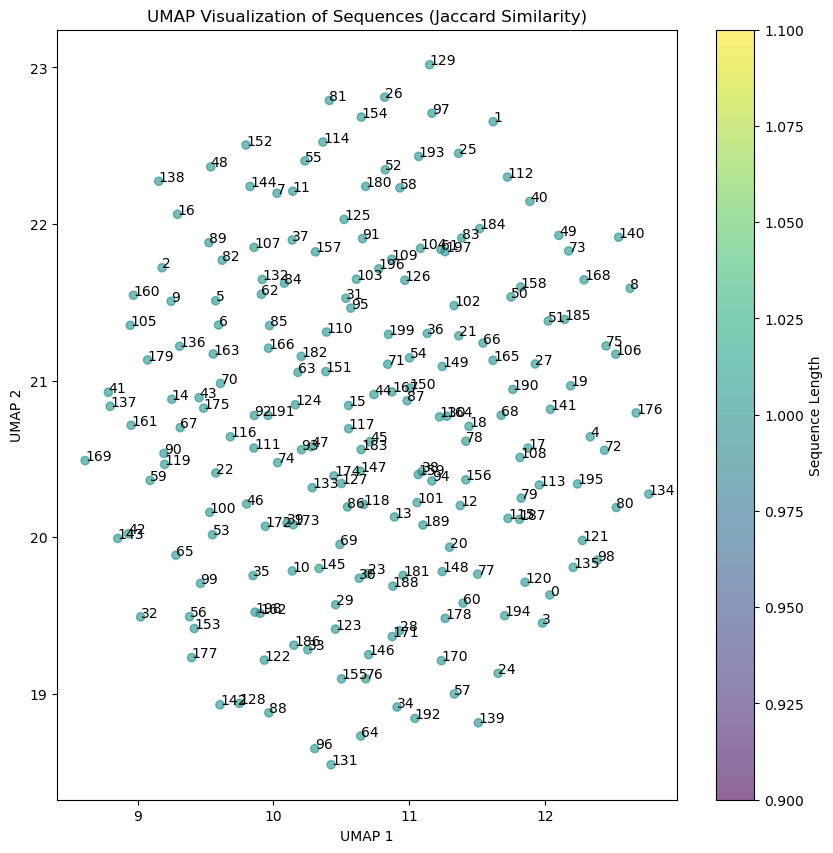

In [46]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Binarize sequences
vocab_size = 519
binary_vecs = np.zeros((len(sequences), vocab_size))
for i, seq in enumerate(sequences):
    binary_vecs[i, seq] = 1

# Compute Jaccard distances
distances = pairwise_distances(binary_vecs, metric='jaccard')

# Apply UMAP
umap = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed'
)
embeddings = umap.fit_transform(distances)

# Create plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                     c=[len(seq) for seq in sequences],
                     cmap='viridis',
                     alpha=0.6)

# Add sequence labels
for i, seq in enumerate(sequences):
    plt.annotate(f'{i}', (embeddings[i, 0], embeddings[i, 1]))

plt.colorbar(scatter, label='Sequence Length')
plt.title('UMAP Visualization of Sequences (Jaccard Similarity)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

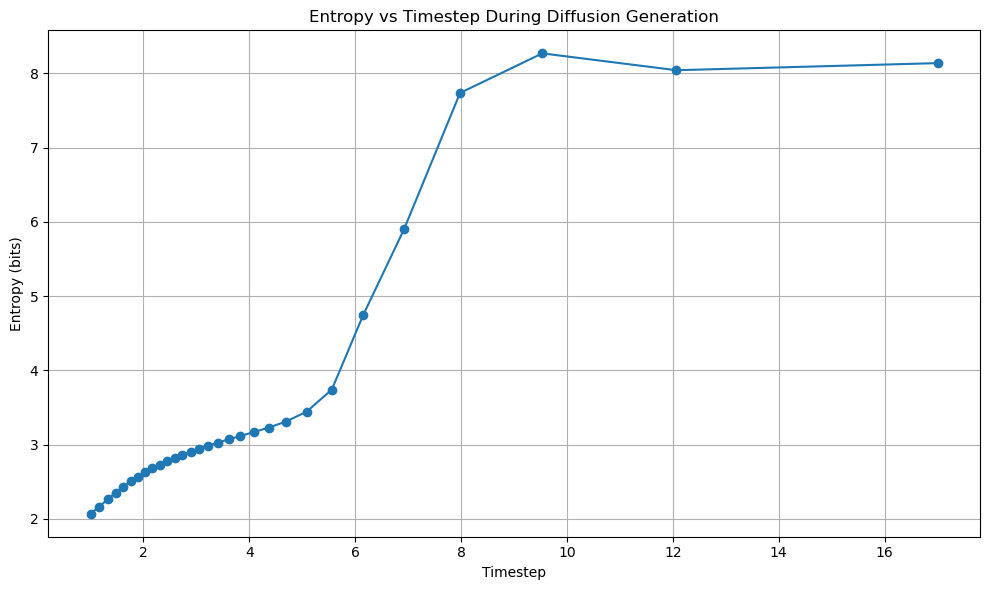

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples and plot entropy against timesteps.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
    """
    # Get timesteps
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    
    # Initialize storage for entropy values
    entropy_values = []
    timestep_values = []
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * timesteps[0]

    def calculate_entropy(probs):
        """Calculate entropy from probability distribution"""
        eps = 1e-10
        entropy = -torch.sum(probs * torch.log2(probs + eps), dim=-1)
        return entropy.mean().item()

    for t in timesteps:
        with torch.no_grad():
            #image = (image / (torch.norm(image, keepdim=True, p=2, dim=-1) + 1e-8)) * math.sqrt(model.embedding_dim)

            # Process time for time embedding
            log_t = torch.log(t.squeeze(-1).squeeze(-1) + 1e-8) / 4
            time_emb = model.time_embedding(log_t)
            #trying this norm
            time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
            time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim)
            # Convert time_emb from [32] to [1, 200, 32]
            time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)

            # Now concatenate along the feature dimension
            current_image = torch.cat([image, time_emb], dim=-1)

            proj_to_transformer_dim = model.embedding_projection(current_image)
            
            # Get predictions
            predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
            
            # Calculate and store entropy
            entropy = calculate_entropy(predicted)
            entropy_values.append(entropy)
            timestep_values.append(t.item())
            
            # Update image
            normalized_embeddings = model.token_embedding.weight / torch.norm(model.token_embedding.weight, keepdim=True, p=2, dim=1)
            update = predicted @ normalized_embeddings
            dt = timesteps[(timesteps <= t).nonzero()[0][-1] + 1] - t if (timesteps <= t).nonzero()[0][-1] < len(timesteps) - 1 else 0
            image = image - dt * ((update - image)/t**0.1)
            

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timestep_values, entropy_values, '-o')
    plt.xlabel('Timestep')
    plt.ylabel('Entropy (bits)')
    plt.title('Entropy vs Timestep During Diffusion Generation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return entropy_values, timestep_values

# Example usage
entropy_values, timestep_values = plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=100,
    n_steps=30,
    t_min = 1,
    t_max = 17
)